In [1]:
import os
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy as sp
from mri.operators import FFT,WaveletN, OWL
from modopt.opt.proximity import GroupLASSO, IdentityProx

from online.generators.column import Column2DKspaceGenerator,  DataOnlyKspaceGenerator
from online.reconstructors import OnlineReconstructor
from online.operators.fourier import ColumnFFT
from utils import implot, load_data, create_cartesian_metrics
from online.metrics import ssos, psnr_ssos

plt.style.use({'figure.facecolor':'white'})

/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "
/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "


(16, 640, 320) complex128
(320, 320) float32
file_brain_AXFLAIR_200_6002462.h5
1


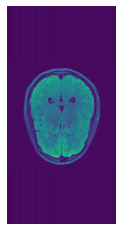

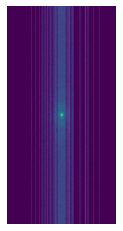

In [2]:
DATA_DIR = "data/"
N_JOBS = 1
results = dict()


full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)
# use mono-coil data
# full_k = sp.fft.ifftshift(sp.fft.fft2(real_img,s=(320,320),norm="ortho"))
# final_mask = crop_center_square(final_mask)
final_k = full_k * final_mask[np.newaxis]
# final_k = full_k * final_mask
implot(real_img)
implot(np.sqrt(np.sqrt(abs(final_k[0]))))

# Type II reconstruction

In [3]:
line_kspace_gen = DataOnlyKspaceGenerator(final_k, mask_loc)
K_DIM = line_kspace_gen.shape[-2:]
N_COILS = line_kspace_gen.shape[0] if full_k.ndim == 3 else 1

line_fourier_op = ColumnFFT(shape=K_DIM, line_index = 0, n_coils=N_COILS, n_jobs=N_JOBS)

In [4]:
linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=N_JOBS)
# initialisation of wavelet transform
linear_op.op(np.zeros_like(final_k))

# Regularizer definition
GL_op = GroupLASSO(weights = 1e-4)
OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)
cost_op_kwargs = {'cost_interval': 1}

100%|██████████| 80/80 [03:59<00:00,  3.00s/it]


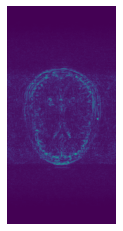

16.423242591355237


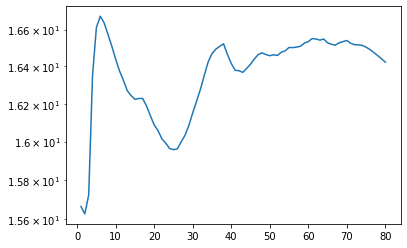

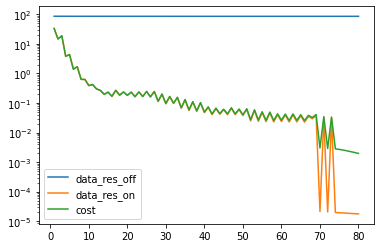

In [5]:
online_pb = OnlineReconstructor(line_fourier_op,
                                linear_op,
                                regularizer_op=GL_op  ,
                                opt='adam',
                                verbose=0)
metrics = create_cartesian_metrics(online_pb, real_img, final_mask, final_k)

xf, costs, metrics_results = online_pb.reconstruct(line_kspace_gen,
                                                   eta=1e-4,
                                                   beta=0.5,
                                                   gamma=0.5,
                                                   cost_op_kwargs=cost_op_kwargs,
                                                   metrics=metrics,
                                                   metric_call_period=1,
                                                   )


implot(ssos(xf))
print(psnr_ssos(xf,real_img))
plt.semilogy(metrics_results['psnr']['index'],
         metrics_results['psnr']['values'],
         label='psnr')
plt.figure()
plt.semilogy(metrics_results['data_res_off']['index'],
         metrics_results['data_res_off']['values'],
         label='data_res_off')

plt.semilogy(metrics_results['data_res_on']['index'],
         metrics_results['data_res_on']['values'],
         label='data_res_on')
plt.semilogy(metrics_results['data_res_off']['index'],
         costs,
         label='cost')
plt.legend()

# 